In [1]:
import numpy as np
import torch
import pandas
from matplotlib import pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from models import Classifier, LegendreLoss, Metrics, find_threshold
from models import find_threshold
np.random.seed(42)

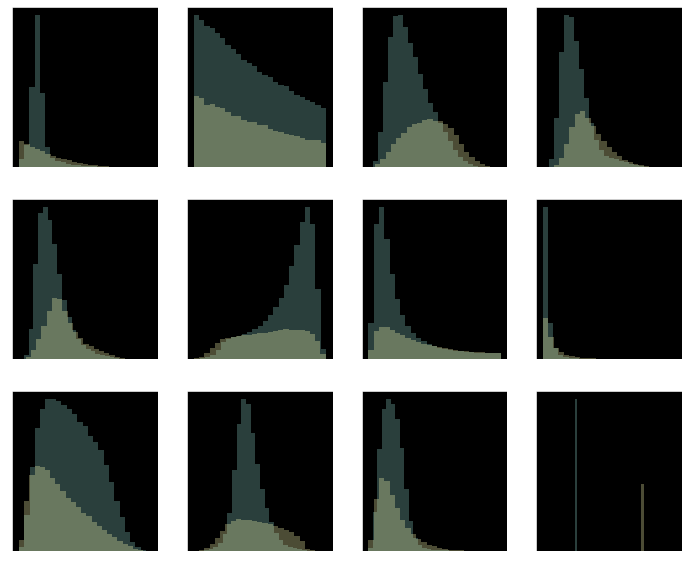

In [2]:
files = np.load("data/W_FCN_v0.npz")
test = files["test"]
train = files["train"]
val = files["val"]
mask = np.arange(train.shape[0])
np.random.shuffle(mask)

fig, axes = plt.subplots(3,4,figsize=(12,10))
for i,ax in enumerate(axes.flatten()):
    ax.hist(train[:,i][train[:,-1]==0],bins=25,alpha=0.3)
    ax.hist(train[:,i][train[:,-1]==1],bins=25,alpha=0.3)
    ax.set_yticks([])

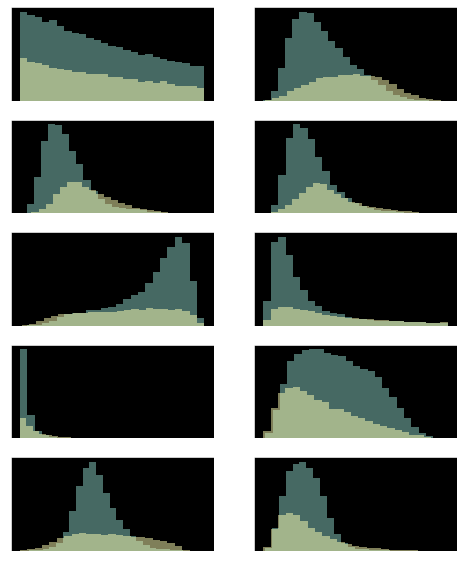

In [10]:
x_train = torch.from_numpy(train[:,1:11]).float()[mask][:59345].view(-1,10)
y_train = torch.from_numpy(train[:,-1]).float().view(-1,1)[mask][:59345]
x_val = torch.from_numpy(val[:,1:11]).float().view(-1,10)
y_val = torch.from_numpy(val[:,-1]).float().view(-1,1)
x_test = torch.from_numpy(test[:,1:5]).float().view(-1,4)
y_test = torch.from_numpy(test[:,-1]).float().view(-1,1)


fig, axes = plt.subplots(5,2,figsize=(8,10))
for i,ax in enumerate(axes.flatten()):
    ax.hist(np.array(x_train[:,i].tolist())[np.array(y_train.view(-1).tolist())==0],alpha=0.5,bins=25)
    ax.hist(np.array(x_train[:,i].tolist())[np.array(y_train.view(-1).tolist())==1],alpha=0.5,bins=25)
    ax.set_yticks([])

In [11]:
ones_frac = np.sum(y_train.tolist())/(y_train.shape[0]-np.sum(y_train.tolist()))
weights = y_train/ones_frac + (1-y_train)
class weighted_mse():
    def __call__(self,pred,target):
        return torch.mean(weights*(pred-target)**2)

In [12]:
print(np.sum(y_train.tolist())/y_train.shape[0])

0.303462802257983


In [15]:
metrics_train = Metrics()
metrics_val = Metrics()

model = Classifier()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4,momentum=0.)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.5)
model.fit(x=x_train,y=y_train,
          val_data=[x_val,y_val],
          n_epochs=2000,
          optimizer= optimizer,
          loss=weighted_mse(),
          #scheduler=scheduler,
          metrics=[metrics_train,metrics_val])

Epoch:0000/2000 || Train: loss:0.6849, acc:70% || Test: loss: 0.7913, acc:20%
Epoch:0100/2000 || Train: loss:0.4818, acc:70% || Test: loss: 0.5118, acc:20%
Epoch:0200/2000 || Train: loss:0.3491, acc:56% || Test: loss: 0.2541, acc:51%
Epoch:0300/2000 || Train: loss:0.3465, acc:58% || Test: loss: 0.2512, acc:49%
Epoch:0400/2000 || Train: loss:0.3447, acc:59% || Test: loss: 0.2493, acc:55%
Epoch:0500/2000 || Train: loss:0.3432, acc:59% || Test: loss: 0.2480, acc:57%
Epoch:0600/2000 || Train: loss:0.3420, acc:59% || Test: loss: 0.2470, acc:57%
Epoch:0700/2000 || Train: loss:0.3409, acc:59% || Test: loss: 0.2462, acc:57%
Epoch:0800/2000 || Train: loss:0.3400, acc:59% || Test: loss: 0.2455, acc:57%
Epoch:0900/2000 || Train: loss:0.3392, acc:60% || Test: loss: 0.2449, acc:57%
Epoch:1000/2000 || Train: loss:0.3386, acc:60% || Test: loss: 0.2445, acc:58%
Epoch:1100/2000 || Train: loss:0.3381, acc:60% || Test: loss: 0.2442, acc:58%
Epoch:1200/2000 || Train: loss:0.3377, acc:60% || Test: loss: 0.

In [20]:
preds = np.array(model.yhat_val.tolist()).flatten()
targets = np.array(y_val.tolist()).flatten()

In [22]:
# find cut such that 0.5 signal (label 0 in this case) is classified correctly
c = find_threshold(preds,(targets==0),0.5)

In [26]:
#fraction of signal that is accepted
(preds[targets==0]<c).sum()/(targets==0).sum()

0.5

In [33]:
# fraction of backgrounds that are accepted (inverted = R50)
R50 = 1/((preds[targets==1]<c).sum()/(targets==1).sum())

In [34]:
R50

2.9641606036108867

In [36]:
from torchsummary import summary
summary(model,(10,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             352
            Linear-2                   [-1, 64]           2,112
            Linear-3                  [-1, 128]           8,320
            Linear-4                    [-1, 1]             129
Total params: 10,913
Trainable params: 10,913
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
